In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
!pip install pandas_profiling
import pandas_profiling
import seaborn as sns

pd.set_option("display.max_columns", None)
%matplotlib inline

# Feature Engineering
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import mutual_info_classif

# Data Splitting
from sklearn.model_selection import train_test_split

# Modelling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

# Evaluation Metrics
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

# Model Export
import joblib


In [3]:
CHUNK_SIZE = 15000
data = pd.read_csv('depressionDataset.csv', chunksize = CHUNK_SIZE)
df = data.get_chunk(CHUNK_SIZE)
df.head()

,id,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,score,class,time,period.name,start.time
0,1,3,2,2,2,3,0,0,0,0,3,15,3,2017-01-22 20:11:59,evening,2017-01-09 07:22:37
1,2,0,3,0,0,0,3,0,0,0,0,6,1,2017-02-08 22:53:06,evening,2017-01-09 07:22:37
2,3,0,0,0,0,0,0,0,0,0,0,0,0,2017-02-08 08:00:46,morning,2017-01-09 07:22:37
3,4,2,1,1,2,0,0,2,3,0,3,14,2,2017-01-22 14:01:25,midday,2017-01-09 07:22:37
4,5,1,3,1,1,2,1,2,3,0,1,15,3,2017-01-21 15:37:24,midday,2017-01-09 07:22:37


# Quick EDA

In [4]:
report = pandas_profiling.ProfileReport(df, minimal=True)
report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From the quick EDA above, we can see there is no missing value in the dataset.
Also, our target variable 'class' is quite balanced

# Visualizing Relations

See how our features affect target variable

In [5]:
# Our target is class
features_names = ['q1','q2','q3','q4','q5','q6','q7','q8','q9','q10']

<Figure size 720x720 with 0 Axes>

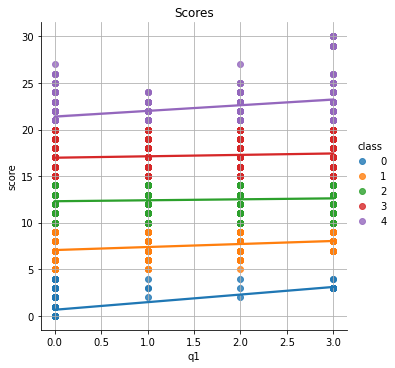

<Figure size 720x720 with 0 Axes>

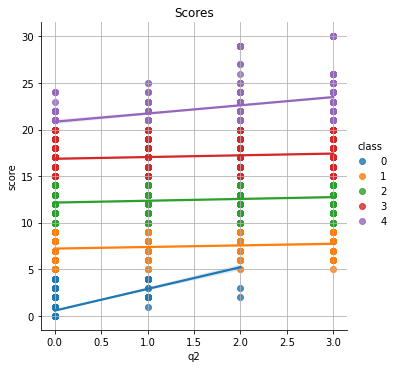

<Figure size 720x720 with 0 Axes>

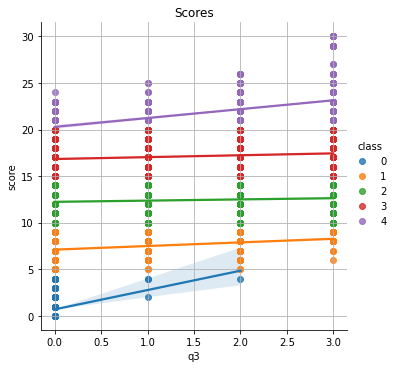

<Figure size 720x720 with 0 Axes>

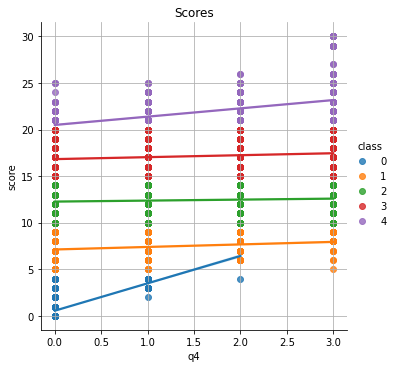

<Figure size 720x720 with 0 Axes>

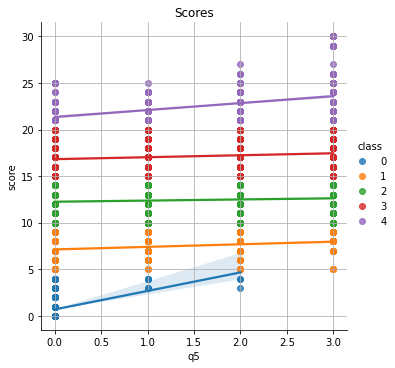

<Figure size 720x720 with 0 Axes>

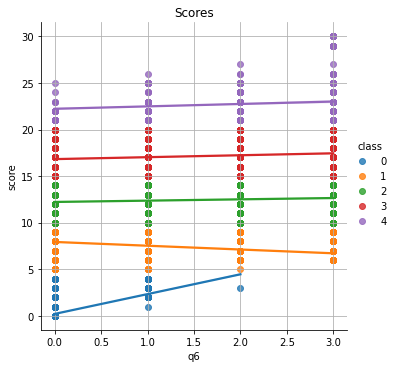

<Figure size 720x720 with 0 Axes>

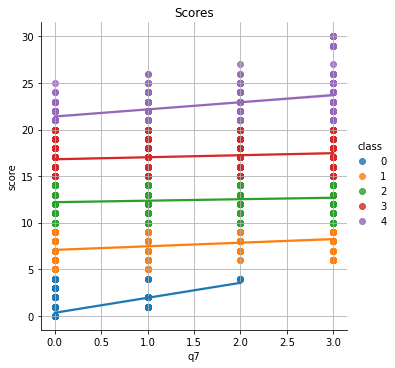

<Figure size 720x720 with 0 Axes>

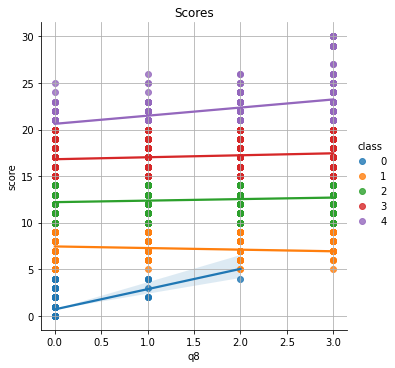

<Figure size 720x720 with 0 Axes>

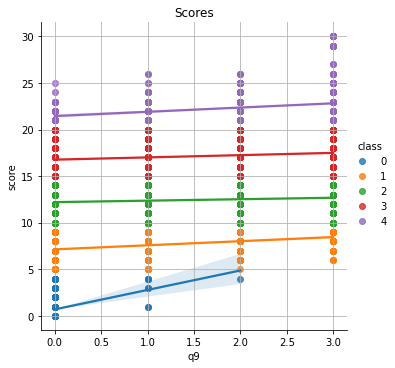

<Figure size 720x720 with 0 Axes>

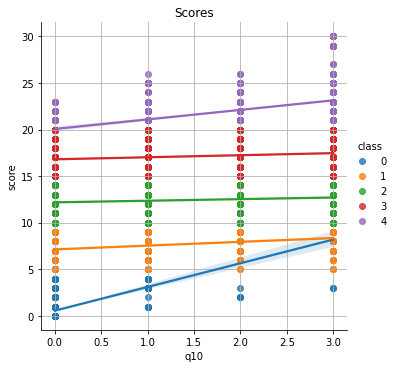

In [6]:
for i in range (0,len(features_names)):
    plt.figure(figsize=(10,10))
    sns.lmplot(x=features_names[i], y="score", data=df, hue='class', legend=True)
    plt.title(f"Scores")
    plt.grid()
    plt.show()

## Visualizing period variable

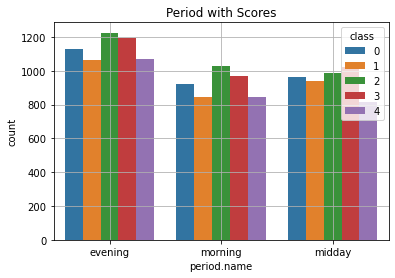

In [7]:
sns.countplot(x="period.name", hue="class",data=df)
plt.title(f"Period with Scores")
plt.grid()
plt.show()


Findings:

Questionaires filled from different period time(ie. evening, morning, midday) did not make huge impact on the class

## Creating new feature

Let's see if the time used to complete the survey affects the target variable

In [8]:
df['time'] = pd.to_datetime(df['time'])
df['start.time'] = pd.to_datetime(df['start.time'])
df['time_used'] = (df['time'] - df['start.time'])/pd.Timedelta('60s')


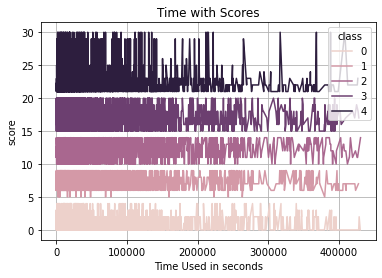

In [9]:
sns.lineplot(x="time_used", y="score", hue="class", data=df)
plt.title(f"Time with Scores")
plt.xlabel("Time Used in seconds")
plt.grid()
plt.show()

Findings:

Time used has no influence to the target variable too

# Feature Engineering

## Drop features
We will be droppping features such as `id`, `time`, `period.name`, `start.time` and `time_used` as these features does not affect our target variable

Also, we should drop `scores` as we only want to classify the depression level.

In [10]:
df.drop(["id", "time", "period.name", "start.time","time_used", "score"], axis=1, inplace=True)

## Compute correlation between features

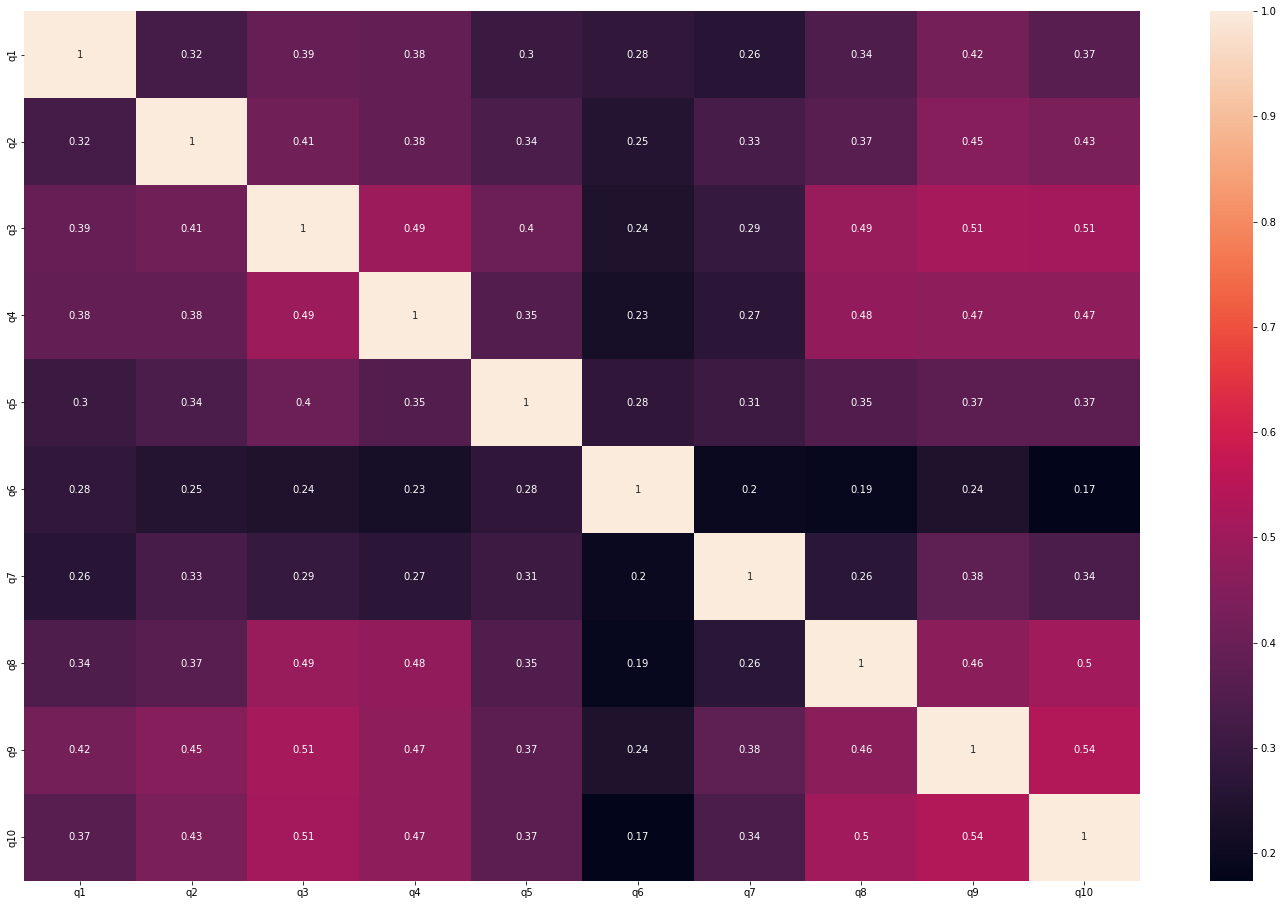

In [11]:
#Heatmap
features = df[features_names]
features.head()

features_corr = features.corr()

plt.figure(figsize=(25,16))
plt.title=(f"Correlation between features")
sns.heatmap(features_corr,annot=True)
plt.show()


In [12]:
#Drop high correlated feature with 95% threshold
features_corr = features_corr.abs()
upper_tri = features_corr.where(np.triu(np.ones(features_corr.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
df = df.drop(df.columns[to_drop], axis=1)
df.head()

C:\Users\zhuol\AppData\Local\Temp\ipykernel_13680\726987765.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = features_corr.where(np.triu(np.ones(features_corr.shape),k=1).astype(np.bool))


,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,class
0,3,2,2,2,3,0,0,0,0,3,3
1,0,3,0,0,0,3,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0
3,2,1,1,2,0,0,2,3,0,3,2
4,1,3,1,1,2,1,2,3,0,1,3


No features were dropped

## Rank feature importance with Mutual Information

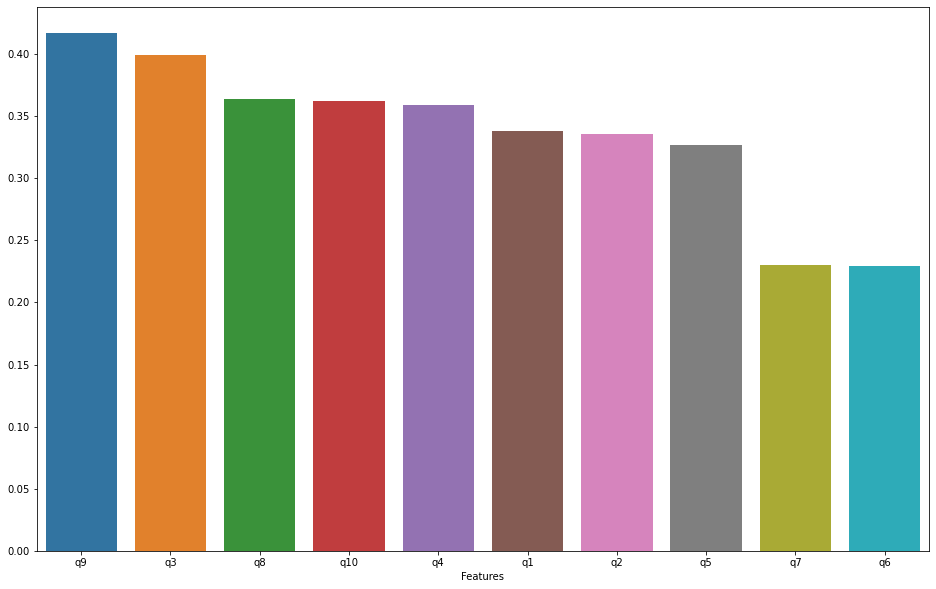

In [13]:
mutual_info = mutual_info_classif(features, df["class"])
mutual_info = pd.Series(mutual_info)
mutual_info.index = features.columns

mutual_info.sort_values(ascending=False,inplace=True)
plt.figure(figsize=(16,10))
sns.barplot(x=mutual_info.index, y=mutual_info)
plt.xlabel("Features")
plt.show()

# Data Splitting and Sampling

In [14]:
#Splitting
y = df.pop("class")


X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.2, random_state=42)


X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12000, 10), (12000,), (3000, 10), (3000,))

In [15]:
X_train

,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10
9839,0,1,1,3,3,0,1,0,1,2
9680,2,2,3,3,1,1,1,3,3,3
7093,0,1,2,2,0,1,2,0,1,3
11293,3,2,2,1,2,3,2,1,3,2
820,3,0,0,0,0,3,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...
5191,2,2,3,3,2,1,1,3,3,3
13418,0,0,0,0,0,0,0,0,0,0
5390,3,2,2,1,2,3,2,1,3,2
860,2,2,2,3,2,3,3,0,3,2


In [16]:
y_train

9839     2
9680     4
7093     2
11293    4
820      1
        ..
5191     4
13418    0
5390     4
860      4
7270     4
Name: class, Length: 12000, dtype: int64

In [17]:
# Normalization
normal_scaler = StandardScaler()

train_features = normal_scaler.fit_transform(X_train)
val_features = normal_scaler.transform(X_test)

X_train = np.clip(train_features, -5, 5)
X_test = np.clip(val_features, -5, 5)


print('Training labels shape:', y_train.shape)
print('Validation labels shape:', y_test.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)


Training labels shape: (12000,)
Validation labels shape: (3000,)
Training features shape: (12000, 10)
Validation features shape: (3000, 10)


# Now, let us compare between different model

1. Neural network
2. KNN
3. Support Vector Machine
4. Random Forest

In [18]:
LABELS = [
    'True None', 'False Mild', 'False Moderate', 'False Moderately Severe', 'False Severe',
    'False None', 'True Mild', 'False Moderate', 'False Moderately Severe', 'False Severe',
    'False None', 'False Mild', 'True Moderate', 'False Moderately Severe', 'False Severe',
    'False None', 'False Mild', 'False Moderate', 'True Moderately Severe', 'False Severe',
    'False None', 'False Mild', 'False Moderate', 'False Moderately Severe', 'True Severe',
]

CATEGORIES = ['0', '1', '2', '3', '4']




## 1. KNN

In [19]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)


KNeighborsClassifier()

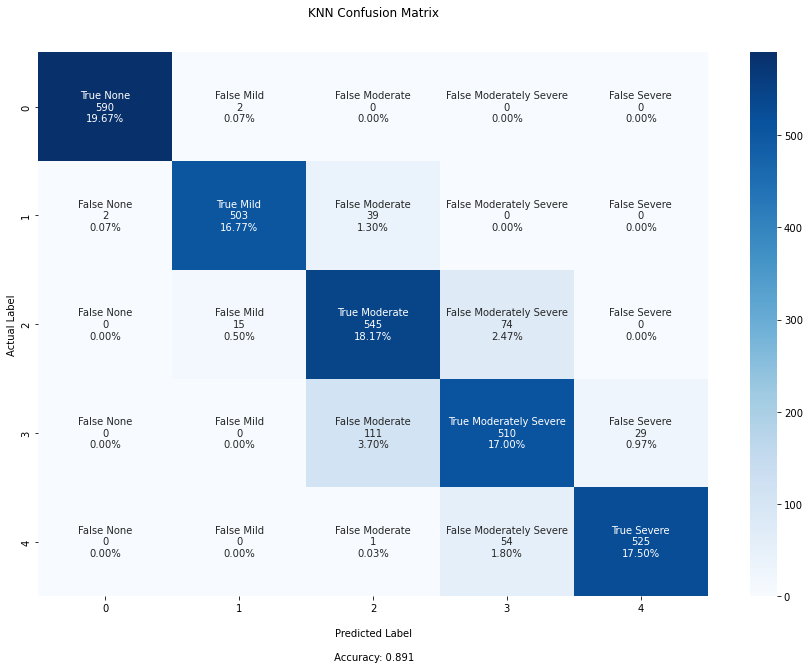

In [20]:
y_pred = knn.predict(X_test)
# y_pred=np.argmax(y_pred, axis=1)
cf_matrix = confusion_matrix(y_test, y_pred)

group_names = LABELS
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(5,5)
plt.figure(figsize=(15,10))
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('KNN Confusion Matrix\n\n');
ax.set_xlabel(f'\nPredicted Label\n\n Accuracy: {np.round(accuracy_score(y_pred,y_test),4)}')
ax.set_ylabel('Actual Label')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(CATEGORIES)
ax.yaxis.set_ticklabels(CATEGORIES)

## Display the visualization of the Confusion Matrix.
plt.show()

In [21]:
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.99662   0.99662   0.99662       592
           1    0.96731   0.92463   0.94549       544
           2    0.78305   0.85962   0.81955       634
           3    0.79937   0.78462   0.79193       650
           4    0.94765   0.90517   0.92593       580

    accuracy                        0.89100      3000
   macro avg    0.89880   0.89413   0.89590      3000
weighted avg    0.89397   0.89100   0.89191      3000



## 2. Support Vector Machine

In [22]:
# X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
#     df, y, test_size=0.3, random_state=42)


# X_train_svm.shape, y_train_svm.shape, X_test_svm.shape, y_test_svm.shape

In [23]:
svm_clf = SVC()

svm_clf.fit(X_train,y_train)

SVC()

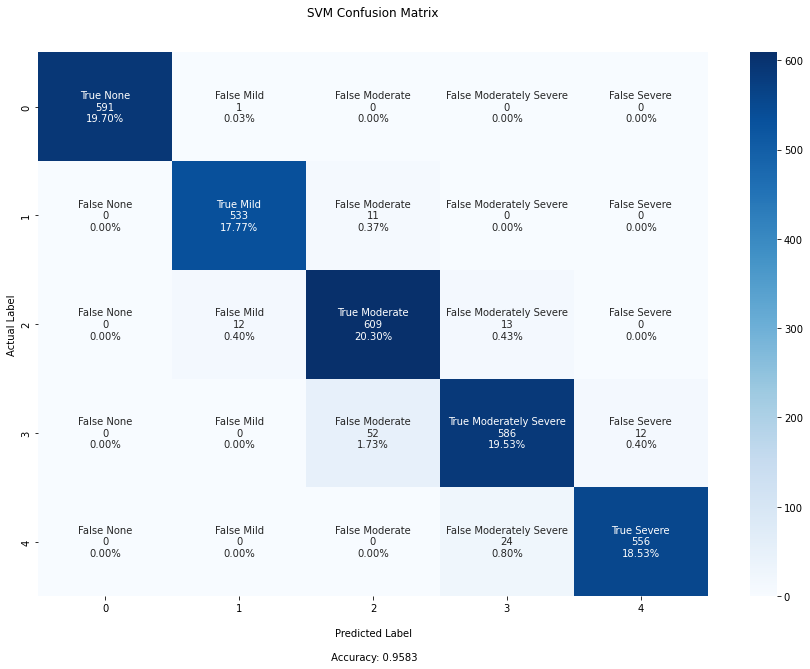

In [24]:
y_pred = svm_clf.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred)

group_names = LABELS
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(5,5)
plt.figure(figsize=(15,10))
ax = sns.heatmap(cf_matrix, annot=labels, fmt='',cmap='Blues')

ax.set_title('SVM Confusion Matrix\n\n');
ax.set_xlabel(f'\nPredicted Label\n\n Accuracy: {np.round(accuracy_score(y_pred,y_test),4)}')
ax.set_ylabel('Actual Label')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(CATEGORIES)
ax.yaxis.set_ticklabels(CATEGORIES)

## Display the visualization of the Confusion Matrix.
plt.show()

In [25]:
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    1.00000   0.99831   0.99915       592
           1    0.97619   0.97978   0.97798       544
           2    0.90625   0.96057   0.93262       634
           3    0.94061   0.90154   0.92066       650
           4    0.97887   0.95862   0.96864       580

    accuracy                        0.95833      3000
   macro avg    0.96038   0.95976   0.95981      3000
weighted avg    0.95892   0.95833   0.95835      3000



## 3. Random Forest

In [26]:
rf_clf = RandomForestClassifier()

rf_clf.fit(X_train, y_train)

RandomForestClassifier()

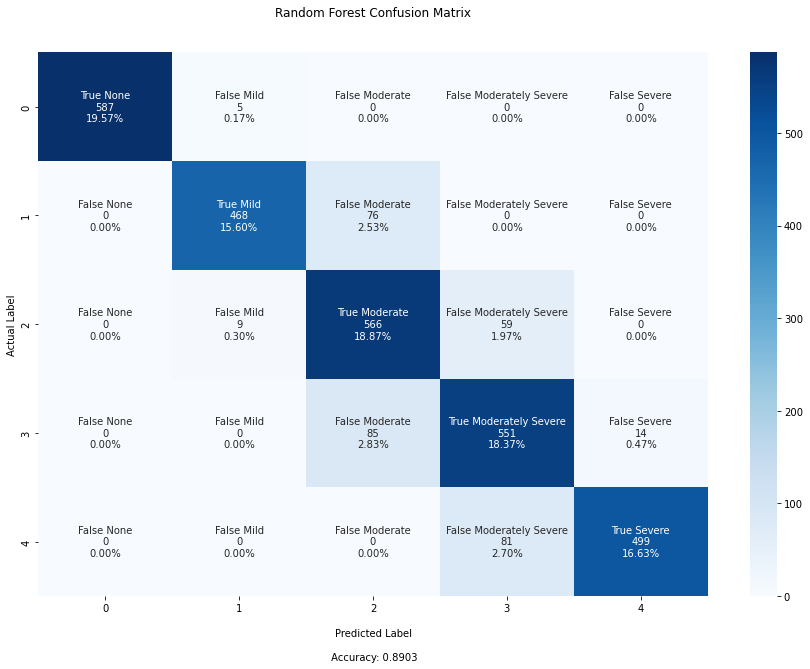

In [27]:
y_pred = rf_clf.predict(X_test)
# y_pred=np.argmax(y_pred, axis=1)
cf_matrix = confusion_matrix(y_test, y_pred)

group_names = LABELS
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(5,5)
plt.figure(figsize=(15,10))
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Random Forest Confusion Matrix\n\n');
ax.set_xlabel(f'\nPredicted Label\n\n Accuracy: {np.round(accuracy_score(y_pred,y_test),4)}')
ax.set_ylabel('Actual Label')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(CATEGORIES)
ax.yaxis.set_ticklabels(CATEGORIES)

## Display the visualization of the Confusion Matrix.
plt.show()

In [28]:
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    1.00000   0.99155   0.99576       592
           1    0.97095   0.86029   0.91228       544
           2    0.77854   0.89274   0.83174       634
           3    0.79740   0.84769   0.82177       650
           4    0.97271   0.86034   0.91308       580

    accuracy                        0.89033      3000
   macro avg    0.90392   0.89053   0.89493      3000
weighted avg    0.89876   0.89033   0.89228      3000



## 4. Neural Network

In [29]:
#Target encoding
y_encoded = to_categorical(y)


y_train, y_test = train_test_split(
    y_encoded, test_size=0.2, random_state=42)


X_train.shape, y_train.shape, X_test.shape, y_test.shape


((12000, 10), (12000, 5), (3000, 10), (3000, 5))

In [30]:
tf.convert_to_tensor(X_train)
tf.convert_to_tensor(X_test)
tf.convert_to_tensor(y_train)
tf.convert_to_tensor(y_test)

KeyboardInterrupt: 

In [ ]:
def buildModel():
    model = keras.Sequential()
    model.add(keras.layers.Dense(10, activation = "relu"))
    model.add(keras.layers.Dense(20, activation = "relu"))
    model.add(keras.layers.Dense(5, activation = "softmax"))

    model.compile(optimizer ='adam', loss = tf.keras.losses.CategoricalCrossentropy(), metrics =['accuracy'])
    return model

In [ ]:
model = buildModel()
model.fit(X_train, y_train, 
validation_split = 0.2, 
epochs = 15,
verbose=1)

Epoch 1/15
300/300 [==============================] - 3s 4ms/step - loss: 0.9130 - accuracy: 0.6554 - val_loss: 0.5166 - val_accuracy: 0.8408
Epoch 2/15
300/300 [==============================] - 1s 4ms/step - loss: 0.3699 - accuracy: 0.8827 - val_loss: 0.2858 - val_accuracy: 0.9162
Epoch 3/15
300/300 [==============================] - 1s 4ms/step - loss: 0.2378 - accuracy: 0.9194 - val_loss: 0.2098 - val_accuracy: 0.9279
Epoch 4/15
300/300 [==============================] - 1s 4ms/step - loss: 0.1920 - accuracy: 0.9325 - val_loss: 0.1807 - val_accuracy: 0.9404
Epoch 5/15
300/300 [==============================] - 1s 4ms/step - loss: 0.1700 - accuracy: 0.9389 - val_loss: 0.1635 - val_accuracy: 0.9429
Epoch 6/15
300/300 [==============================] - 1s 5ms/step - loss: 0.1587 - accuracy: 0.9407 - val_loss: 0.1545 - val_accuracy: 0.9450
Epoch 7/15
300/300 [==============================] - 1s 4ms/step - loss: 0.1487 - accuracy: 0.9448 - val_loss: 0.1488 - val_accuracy: 0.9525
Epoch 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 20)                220       
                                                                 
 dense_2 (Dense)             (None, 5)                 105       
                                                                 
Total params: 435
Trainable params: 435
Non-trainable params: 0
_________________________________________________________________


94/94 [==============================] - 0s 2ms/step


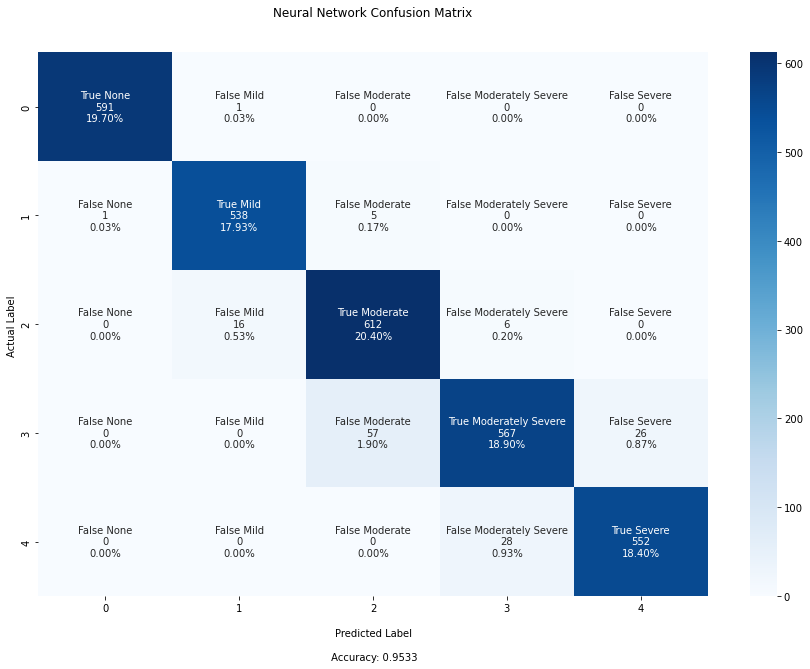

In [ ]:
y_testt=np.argmax(y_test, axis=1)


y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)

cf_matrix = confusion_matrix(y_testt, y_pred)

group_names = LABELS
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(5,5)

plt.figure(figsize=(15,10))
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Neural Network Confusion Matrix\n\n');
ax.set_xlabel(f'\nPredicted Label\n\n Accuracy: {np.round(accuracy_score(y_pred,y_testt),4)}')
ax.set_ylabel('Actual Label ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(CATEGORIES)
ax.yaxis.set_ticklabels(CATEGORIES)

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
results = model.evaluate(X_test, y_test)
print(f'Test loss: {results[0]}, test accuracy: {results[1]}')

94/94 [==============================] - 0s 4ms/step - loss: 0.1355 - accuracy: 0.9533
Test loss: 0.13554835319519043, test accuracy: 0.95333331823349


In [ ]:
print(classification_report(y_testt, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.99831   0.99831   0.99831       592
           1    0.96937   0.98897   0.97907       544
           2    0.90801   0.96530   0.93578       634
           3    0.94343   0.87231   0.90647       650
           4    0.95502   0.95172   0.95337       580

    accuracy                        0.95333      3000
   macro avg    0.95483   0.95532   0.95460      3000
weighted avg    0.95372   0.95333   0.95302      3000



From the model above we can see the accuracy of each model, from highest to lowest:
1. Support Vector Machine - 0.9583
2. Neural Network the highest - 0.9533
3. Random Forest - 0.8903
4. KNN - 0.891

# Model Export
We will export all models

In [ ]:
joblib.dump(knn, 'knn_model.pkl')
joblib.dump(svm_clf, 'svm_model.pkl')
joblib.dump(rf_clf, 'rf_model.pkl')
model.save('nn_model.h5')